### ***Deep Learning for Channel Coding via Neural Mutual Information Estimation***





This code sets up and trains an autoencoder for 16-QAM communication systems using deep learning.

- It defines the autoencoder's architecture and functionality, including encoding, adding noise, and decoding. It also includes a neural network for estimating mutual information, which is used to optimize the autoencoder's performance.

- The training process involves multiple epochs and steps, adjusting the encoder, decoder, and mutual information estimator through gradient-based optimization. Finally, the code tests the autoencoder's performance by evaluating its bit error rate across a range of signal-to-noise ratios, providing insights into its effectiveness under different conditions.

In [ ]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from scipy import special
from tensorflow import keras
import matplotlib.pyplot as plt
assert sys.version_info >= (3, 5)


# ------------------------------------ Set random seeds for reproducibility ------------------------------------
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
class AutoEncoder:
    def __init__(self, M=16, n=1, training_snr=7, rayleigh=False):
        self.M = M
        self.k = int(np.log2(M))
        self.n = n
        self.training_snr = training_snr
        self.rayleigh = rayleigh
        self.noise_std = self.EbNo_to_noise(training_snr)

        # Define custom layers
        self.norm_layer = keras.layers.Lambda(lambda x: tf.divide(x, tf.sqrt(2 * tf.reduce_mean(tf.square(x)))))
        self.shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1, 2, n]))
        self.shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1, 2 * n]))
        self.channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=self.noise_std))

        # Define the encoder model
        self.encoder = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal', input_length=1),
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(2 * n, activation=None),
            self.shape_layer,
            self.norm_layer
        ])

        # Define the channel model
        if rayleigh:
            self.channel = keras.models.Sequential([keras.layers.Lambda(lambda x: self.sample_Rayleigh_channel(x, self.noise_std))])
        else:
            self.channel = keras.models.Sequential([self.channel_layer])

        # Define the decoder model
        self.decoder = keras.models.Sequential([
            keras.layers.InputLayer(input_shape=[2, n]),
            self.shape_layer2,
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(M, activation="softmax")
        ])

        # Combine encoder, channel, and decoder into an autoencoder model
        self.autoencoder = keras.models.Sequential([self.encoder, self.channel, self.decoder])

    def EbNo_to_noise(self, ebnodb):
        '''Transform EbNo[dB]/snr to noise power'''
        ebno = 10**(ebnodb/10)
        noise_std = 1/np.sqrt(2*(self.k/self.n)*ebno)
        return noise_std

    def sample_Rayleigh_channel(self, x, noise_std):
        h_sample = (1/np.sqrt(2)) * tf.sqrt(tf.random.normal(tf.shape(x))**2 + tf.random.normal(tf.shape(x))**2)
        z_sample = tf.random.normal(tf.shape(x), stddev=noise_std)
        y_sample = x + tf.divide(z_sample, h_sample)
        return tf.cast(y_sample, tf.float32)

    def random_sample(self, batch_size=32):
        msg = np.random.randint(self.M, size=(batch_size, 1))
        return msg

    def B_Ber_m(self, input_msg, msg):
        '''Calculate the Batch Bit Error Rate'''
        batch_size = input_msg.shape[0]
        pred_error = tf.not_equal(tf.reshape(input_msg, shape=(-1, batch_size)), tf.argmax(msg, 1))
        bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
        return bber

    def test_encoding(self):
        inp = np.arange(0, self.M)
        coding = self.encoder.predict(inp)
        fig = plt.figure(figsize=(4,4))
        plt.plot(coding[:,0], coding[:, 1], "b.")
        plt.xlabel("$x_1$", fontsize=18)
        plt.ylabel("$x_2$", fontsize=18, rotation=0)
        plt.grid(True)
        plt.gca().set_ylim(-2, 2)
        plt.gca().set_xlim(-2, 2)
        plt.show()

In [ ]:
class NNFunction(tf.keras.Model):
    def __init__(self, hidden_dim, layers, activation, **extra_kwargs):
        super(NNFunction, self).__init__()
        self._f = tf.keras.Sequential(
            [tf.keras.layers.Dense(hidden_dim, activation) for _ in range(layers)] +
            [tf.keras.layers.Dense(1)]
        )

    def call(self, x, y):
        batch_size = tf.shape(x)[0]
        x_tiled = tf.tile(x[None, :], (batch_size, 1, 1))
        y_tiled = tf.tile(y[:, None], (1, batch_size, 1))
        xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1])
        scores = self._f(xy_pairs)
        return tf.transpose(tf.reshape(scores, [batch_size, batch_size]))

In [ ]:
class Trainer:
    def __init__(self, autoencoder, nn_function):
        self.autoencoder = autoencoder
        self.nn_function = nn_function
        self.loss_fn = keras.losses.SparseCategoricalCrossentropy()
        self.mean_loss = keras.metrics.Mean()

    def MINE(self, scores):
        def marg(x):
            batch_size = x.shape[0]
            marg_ = tf.reduce_mean(tf.exp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size))))
            return marg_ * ((batch_size * batch_size) / (batch_size * (batch_size - 1.)))
        joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
        marg_term = marg(scores)
        return joint_term - tf.math.log(marg_term)

    def plot_loss(self, step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
        template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        if step % 10 == 0:
            print(template.format(step, epoch, mean_loss.result(), self.autoencoder.B_Ber_m(X_batch, y_pred)))
            if plot_encoding:
                self.autoencoder.test_encoding()

    def plot_batch_loss(self, epoch, mean_loss, X_batch, y_pred):
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        print(template_outer_loop.format(epoch, mean_loss.result(), self.autoencoder.B_Ber_m(X_batch, y_pred)))

    def train_mi(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005):
        optimizer_mi = keras.optimizers.Nadam(lr=learning_rate)
        for epoch in range(1, n_epochs + 1):
            print("Training in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)
                with tf.GradientTape() as tape:
                    x_enc = self.autoencoder.encoder(X_batch, training=True)
                    y_recv = self.autoencoder.channel(x_enc)
                    x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])
                    y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])
                    score = self.nn_function(x, y)
                    loss = -self.MINE(score)
                    gradients = tape.gradient(loss, self.nn_function.trainable_variables)
                    optimizer_mi.apply_gradients(zip(gradients, self.nn_function.trainable_variables))
                mi_avg = -self.mean_loss(loss)
            print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))
            self.mean_loss.reset_states()

    def train_decoder(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005, plot_encoding=True):
        optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)
        for epoch in range(1, n_epochs + 1):
            print("Training Bob in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)
                with tf.GradientTape() as tape:
                    y_pred = self.autoencoder.autoencoder(X_batch, training=True)
                    loss = tf.reduce_mean(self.loss_fn(X_batch, y_pred))
                    gradients = tape.gradient(loss, self.autoencoder.decoder.trainable_variables)
                    optimizer_ae.apply_gradients(zip(gradients, self.autoencoder.decoder.trainable_variables))
                self.mean_loss(loss)
                self.plot_loss(step, epoch, self.mean_loss, X_batch, y_pred, plot_encoding)
            self.plot_batch_loss(epoch, self.mean_loss, X_batch, y_pred)
            self.mean_loss.reset_states()

    def train_encoder(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.05):
        optimizer_mi = keras.optimizers.Nadam(lr=0.005)
        optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)
        for epoch in range(1, n_epochs + 1):
            print("Training Bob in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)
                with tf.GradientTape() as tape:
                    x_enc = self.autoencoder.encoder(X_batch, training=True)
                    y_recv = tf.grad_pass_through(self.autoencoder.channel)(x_enc) #forward pass:channel; backward pass Identity
                    x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])
                    y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])
                    score = self.nn_function(x, y)
                    loss = -self.MINE(score)
                    gradients = tape.gradient(loss, self.autoencoder.encoder.trainable_variables)
                    optimizer_ae.apply_gradients(zip(gradients, self.autoencoder.encoder.trainable_variables))
                mi_avg = -self.mean_loss(loss)
            with tf.GradientTape() as tape:
                X_batch = self.autoencoder.random_sample(batch_size)
                x_enc = self.autoencoder.encoder(X_batch, training=True)
                y_recv = self.autoencoder.channel(x_enc)
                x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])
                y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])
                score = self.nn_function(x, y)
                loss = -self.MINE(score)
                gradients = tape.gradient(loss, self.nn_function.trainable_variables)
                optimizer_mi.apply_gradients(zip(gradients, self.nn_function.trainable_variables))
            print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))

    def Test_AE(self):
        '''Calculate Bit Error for varying SNRs'''
        snr_range = np.linspace(0, 15, 31)
        bber_vec = [None] * len(snr_range)
        for db in range(len(snr_range)):
            for it in range(1, 1000):
                noise_std = self.autoencoder.EbNo_to_noise(snr_range[db])
                X_batch = self.autoencoder.random_sample(500)
                code_word = self.autoencoder.encoder(X_batch)
                if self.autoencoder.rayleigh:
                    rcvd_word = self.autoencoder.sample_Rayleigh_channel(code_word, noise_std)
                else:
                    rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
                dcoded_msg = self.autoencoder.decoder(rcvd_word)
                bber = self.autoencoder.B_Ber_m(X_batch, dcoded_msg)
                bber_avg = self.mean_loss(bber)
            bber_vec[db] = bber_avg
            self.mean_loss.reset_states()
            if (db % 6 == 0) & (db > 0):
                print(f'Progress: {db} of {30} parts')
        return (snr_range, bber_vec)

Training in Epoch 1/1


Epoch: 1, Mi is 1.3992865085601807
Training Encoder in Epoch 1/5
Epoch: 1, Mi is 1.7451244592666626
Training Encoder in Epoch 2/5
Epoch: 2, Mi is 1.741653323173523
Training Encoder in Epoch 3/5
Epoch: 3, Mi is 1.7374783754348755
Training Encoder in Epoch 4/5
Epoch: 4, Mi is 1.743280053138733
Training Encoder in Epoch 5/5
Epoch: 5, Mi is 1.734639286994934
1/1 [==============================] - 0s 178ms/step


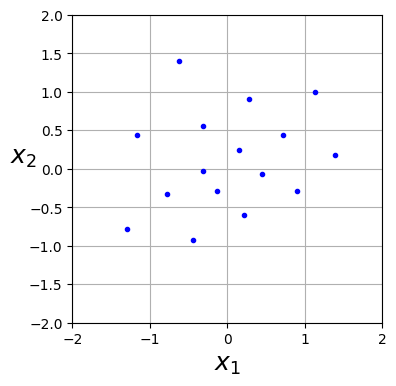

Training Decoder in Epoch 1/5
Iteration: 10, Epoch: 1, Loss: -1.71178, Batch_BER: 0.94200
Iteration: 20, Epoch: 1, Loss: -1.68937, Batch_BER: 0.95400
Iteration: 30, Epoch: 1, Loss: -1.66733, Batch_BER: 0.92600
Iteration: 40, Epoch: 1, Loss: -1.64578, Batch_BER: 0.90200
Iteration: 50, Epoch: 1, Loss: -1.62462, Batch_BER: 0.88400
Iteration: 60, Epoch: 1, Loss: -1.60386, Batch_BER: 0.86000
Iteration: 70, Epoch: 1, Loss: -1.58353, Batch_BER: 0.84400
Iteration: 80, Epoch: 1, Loss: -1.56356, Batch_BER: 0.81200
Iteration: 90, Epoch: 1, Loss: -1.54399, Batch_BER: 0.73800
Iteration: 100, Epoch: 1, Loss: -1.52477, Batch_BER: 0.74800
Iteration: 110, Epoch: 1, Loss: -1.50584, Batch_BER: 0.74200
Iteration: 120, Epoch: 1, Loss: -1.48732, Batch_BER: 0.68600
Iteration: 130, Epoch: 1, Loss: -1.46914, Batch_BER: 0.72400
Iteration: 140, Epoch: 1, Loss: -1.45129, Batch_BER: 0.76200
Iteration: 150, Epoch: 1, Loss: -1.43377, Batch_BER: 0.65400
Iteration: 160, Epoch: 1, Loss: -1.41652, Batch_BER: 0.68800
Ite

In [ ]:
# Initialize models and trainer
autoencoder = AutoEncoder(M=16, n=1, training_snr=7, rayleigh=True)
score_fn = NNFunction(layers=2, hidden_dim=256, activation='relu')

trainer = Trainer(autoencoder, score_fn)
trainer.train_mi(n_epochs=1, n_steps=500, batch_size=64)
trainer.train_encoder(n_epochs=5, n_steps=400, batch_size=64, learning_rate=0.005)
trainer.autoencoder.test_encoding()
trainer.train_decoder(n_epochs=5, n_steps=400, batch_size=500, learning_rate=0.005, plot_encoding=False)
bber_data = trainer.Test_AE()

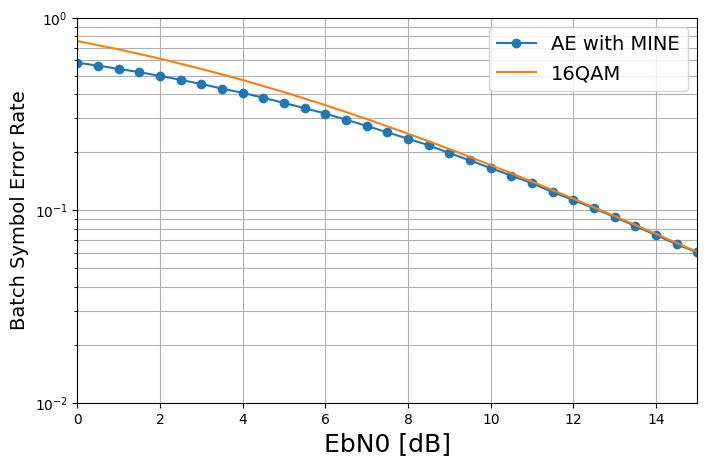

In [ ]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

def MQAM_rayleigh_approx(M, ebnodb):
    ebno = 10.**(ebnodb/10)
    esno = 4*ebno
    a=3.25
    b=3/(M-1)
    e=b*esno
    return (a/2)*(1-np.sqrt(0.5*e / (1+0.5*e) ) ), a/(2*b*esno)

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(bber_data[0], bber_data[1], 'o-')
a, b = MQAM_rayleigh_approx(16,ebnodbs)
plt.plot(ebnodbs, a);
plt.gca().set_ylim(1e-2, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("EbN0 [dB]", fontsize=18)
plt.legend(['AE with MINE', '16QAM'], prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")